#  Intro to Gibbs Sampling

##### Keywords: MCMC, gibbs sampler, transition matrix, autocorrelation

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm, gamma
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')

## Summary

We introduce the basic idea of gibbs as a markov chain in which the transition matrix can be obtained as the kernel of an integral fixed point equation by sampling alternatively from two conditionals. We work out a simple example.

---

## The basic idea

Gibbs determined the energy states of gases at equilibrium by cycling through all the particles, drawing from each one of them conditionally given the enerygy levels of the others, taking the time average. He showed that the time average approached the equilibrium distribution. Geman and Geman used this idea to denoise images.

Suppose you have a density  of two variables $f_{XY}(x,y)$. You wish to sample from this density.

The definition of the $X$ marginal is

$$f_X(x) = \int f_{XY}(x,y) dy$$

(we'll drop subscripts from this point onwards)

$$f(x) = \int f(x \vert y) f(y) dy = \int dy f(x \vert y) \int dx' f( y \vert x') f(x') $$

Thus:

$$f(x) = \int h(x, x') f(x') dx'$$

where

$$h(x,x') = \int dy f(x \vert y) f(y \vert x').$$

Now consider an iterative scheme in which the "transition kernel" $h(x, x')$ is used to create a proposal for metropolis-hastings moves. This looks like:

$$f(x_t) = \int h(x_t, x_{t-1}) f(x_{t-1}) dx_{t-1}$$

which is the equation of a stationary distribution.

The big idea, then, here, as in the case of markov chains, is that the above equation can be thought of as a fixed-point integral equation, and thus we can think of an iterative process which at first does not satisy this condition but then does as time goes on and we reach stationarity. 

But now look at the equation for the kernel $h(x,x')$. You have seen an equation like this before when we write a posterior predictive by integrating over the parameters $\theta$. There we draw $\theta$ from the posterior and then $y^*$ from the likelihood given $\theta$, thus giving us samples of the joint distribution $p(y^*, \theta)$.

Similarly here, if we draw $y$, from the conditional  $f(y \vert x')$ and then $x$ again from  $f(x \vert y)$ we will be able to get the marginal distribution of $x$. Symmetrically we can get the marginal for $y$.

Now, if I can draw from the $x$ marginal, and the $y \vert x$ conditional, i can draw from the $x, y$ joint, and I am done. 

## An example

Let us consider a 2-D distribution which we wish to sample from.

$$f(x,y) = x^2 {\rm exp}[-xy^2 - y^2 + 2y - 4x]$$

Here's what the distribution really looks like.

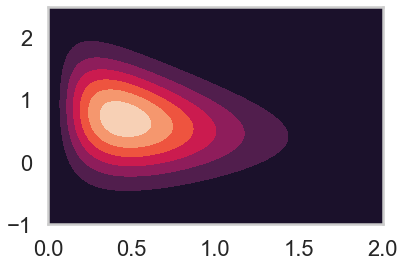

In [2]:

func = lambda x,y: x**2*np.exp( -x*y**2 - y**2 + 2*y - 4*x )

numgridpoints=400
x = np.linspace(0,2,numgridpoints)
y = np.linspace(-1,2.5,numgridpoints)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((numgridpoints,numgridpoints))
for i in np.arange(0,numgridpoints):
    for j in np.arange(0,numgridpoints):
        zz[i,j]=func(xx[i,j],yy[i,j])
        
plt.contourf(xx,yy,zz);

On first glance the functional form of this distribution looks terrible and difficult to deal with. 

However, Gibbs Sampling comes to the rescue. The power of the Gibbs sampler is that you can directly sample from the conditionals alternately. 

Let us do a little math to construct the functional form of the conditionals and express them in terms of distributions we know how to sample from. 

We have:

$$f(x,y) = x^2 {\rm exp}[-xy^2 - y^2 + 2y - 4x]$$

Now assume we hold $y$ constant:

$$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)]{\rm exp}[- y^2 + 2y]$$

$$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)] g(y)$$

where $g(y) = {\rm exp}[- y^2 + 2y]$. Thus:

$$f(x|y) = g(y){\rm Gamma}(3,y^2+4)$$

In [3]:
def xcond(y):
    return gamma.rvs(3, scale=1/(y*y + 4))

then assume we hold $x$ constant...

$$f(y|x) = x^2 {\rm exp}[-y^2(1+x) + 2y]{\rm exp}[-4x]$$

$$f(y|x) = x^2 {\rm exp}[-y^2(1+x) +2y - \frac{1}{1+x}]\, {\rm exp}[-4x]\,{\rm exp}[\frac{1}{1+x}]$$

$$f(y|x) = x^2 {\rm exp}[-(1+x)(y^2 - 2y\frac{1}{1+x} + \frac{1}{(1+x)^2})]{\rm exp}[-4x]$$

Writing $h(x) = x^2 {\rm exp}[-4x]$ we have 

$$f(y|x) = N(\frac{1}{1+x},\frac{1}{\sqrt{(2(1+x))}}) h(x)$$

In [4]:
def ycond(x):
    return norm.rvs(1/(1+x), scale=1.0/np.sqrt(2*(x+1)))

So we can use Gibbs sampler to select directly from the functional forms of the conditionals because we know how to sample from a Normal distribution and we know how to sample from a Gamma distribution. 

The key thing which makes Gibbs useful is **knowing how to directly sample from the conditionals**.

## The sampler

In [5]:
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((N+1, 2))
    samples[0,0]=x
    samples[0,1]=y
    
    for i in range(1,N,2):
        x=xgiveny_sample(y)
        samples[i,0]=x
        samples[i, 1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
        
    return samples

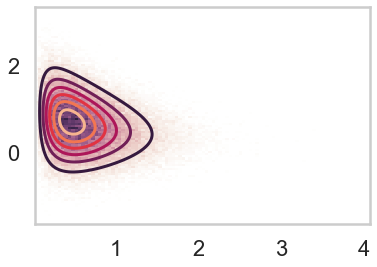

In [7]:
out=gibbs(xcond, ycond, 100000)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[10000:,0],out[10000:,1], density=True, bins=100, cmap=cmap)
plt.contour(xx,yy,zz)
plt.show()

### Gibbs Moves

Let's look at the single steps the Gibbs sampler is taking:

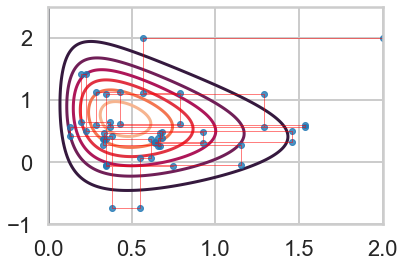

In [8]:
out=gibbs(xcond, ycond, 10000, start = [2,2])
nr_t = 50
plt.contour(xx,yy,zz)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], '.',alpha=0.8)
plt.plot(out[:nr_t, 0],out[:nr_t, 1], c='r', alpha=0.5, lw=1)

### Autocorrelation

Looking at the autocorrelation of our samples we are in pretty good shape and probably don't have to worry much about thinning here. Note that this is not always the case for Gibbs sampling. The other notebook has an example where we need to have a lot of thinning to account for the autocorrelation of the samples. It all depends on the shape of our target distribution. 

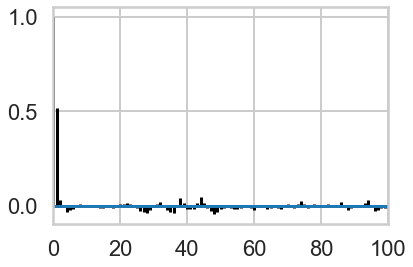

In [9]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
corrplot(out[4000:,0], 100)

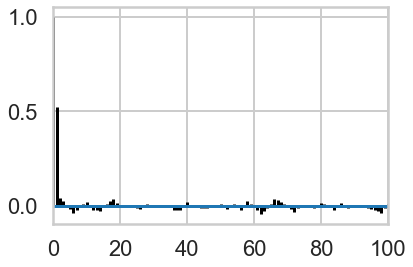

In [10]:
corrplot(out[4000:,1], 100)

Generally, gibbs samplers can show a lot of autocorrelation, needing quite a bit of thinning. This is especially true when the functions you are sampling from have lots of correlation amongst the components. But as in all MCMC algorithms, the number of samples needed depends on what you are doing. Fully characterizing a posterior needs a lot of samples, but  you might be able to get away with less in computing expectations...